## Dunnhumby: The Complete Journey

February 2022

Nathaniel Poland 

[linkedin.com/in/nate-poland](linkedin.com/in/nate-poland)

[github.com/np1919](github.com/np1919)

# Making Household Dashboards

This is a technical summary of the functions included in the development package which form the data pipeline for this project. In it, we will create the contents of the /outputs/ folder; 

`hh_agg`, `hh_weekly`, `merged`, `merged_demo`

and summarize the process in the ETL function. This will allow others to download the repo and form the necessary tables for the Analysis and Modelling techniques in the next workbooks.

---

## import modules and `check_dfs`

In [1]:
#import modules 
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,6)
plt.style.use('seaborn')

import datetime
import glob

#
# import my_funcs

# my_funcs.ETL()


In [2]:
def check_dfs(subfolder='data'):
    
    # names of .csv files in in the data folder of the notebook's directory;
    data_files = glob.glob(f'{subfolder}/*.csv')
    
    # containers
    num_files = len(data_files)
    output = pd.DataFrame()
    
    for idx, file in enumerate(data_files):
        df = pd.read_csv(file)
        name = file.split("\\")[-1][:-4] # filename -extension
        shape = df.shape
        nulls = df.isna().sum().sum()
        columns = list(df.columns)
        num_cols = len(df.columns)
        
        output = output.append(pd.Series([name, shape, nulls, num_cols, columns]), ignore_index=True)
    output.columns =  ['name', 'shape', 'nulls', 'num_cols', 'columns']
    output[['nulls' ,'num_cols']] = output[['nulls' ,'num_cols']].astype(int)
    return output

check_dfs()

,name,shape,nulls,num_cols,columns
0,campaign_desc,"(30, 4)",0,4,"[DESCRIPTION, CAMPAIGN, START_DAY, END_DAY]"
1,campaign_table,"(7208, 3)",0,3,"[DESCRIPTION, household_key, CAMPAIGN]"
2,causal_data,"(36786524, 5)",0,5,"[PRODUCT_ID, STORE_ID, WEEK_NO, display, mailer]"
3,coupon,"(124548, 3)",0,3,"[COUPON_UPC, PRODUCT_ID, CAMPAIGN]"
4,coupon_redempt,"(2318, 4)",0,4,"[household_key, DAY, COUPON_UPC, CAMPAIGN]"
5,hh_demographic,"(801, 8)",0,8,"[AGE_DESC, MARITAL_STATUS_CODE, INCOME_DESC, H..."
6,product,"(92353, 7)",0,7,"[PRODUCT_ID, MANUFACTURER, DEPARTMENT, BRAND, ..."
7,transaction_data,"(2595732, 12)",0,12,"[household_key, BASKET_ID, DAY, PRODUCT_ID, QU..."


Above, we can see the name; shape; nulls; and columns for each table in the dataset.

# Exploratory Data Analysis to Extract Transform Load

    ''' Issues and Solutions inside the Data '''


As we'll see, there are some steps necessary in order to get the data into a serviceable state. In the process I was forced to perform various data cleaning and even truncations of sections of the data; however before doing so, I tried to learn as much as I could about the problem space.

8 tables was a lot for a total noob like me, and it's taught me a lot about the iterative process, python modules and packages. It's given me a limited idea of how a real-world workflow might begin to take shape. 

## Transactions and Products EDA

    '''   Creating Household Aggregate information; 
                    Cleaning Sales Data; 
                      Adding datetime                 '''

 
### **`product.csv`:**

*INPUTS:*

- too many `COMMODITY_DESC` categories (similar/obscure product types listed)
- incomplete/nondescriptive sub-categories `SUB_COMMODITY_DESC`
- `DEPARTMENT` labels inconsistent or incongruent; class imbalances
- total sum of sales is over 8 million dollars

*OUTPUTS:*

`section labels`:

- manually-generated product map for transactions by `COMMODITY_DESC`
- currently only suitable for static data (hardcoded fix)
- 15 simple categories
        
`section sales`:
- sales by section added to `hh_agg` and `hh_tensors`
   

## Products

For products, we have a new `Section Labels` map which we can apply to the `COMMODITY_DESC` column of `merged.csv`; to follow.

### Section Labels

These Section Labels were hard-coded manually; I've included them in the repo.

This is a map which returns the section labels for a given dataframe `df`, which has a `COMMODITY_DESC` column...

In [10]:
def section_labels() -> dict:
    with open('data/outputs/Section_Labels.txt', 'r') as f:
        d = eval(f.read())
        return d
type(section_labels())

dict

Using the map function, we can pass a dataframe and return the labels. This could be modified to become a generator, for streaming data. 

In [11]:
def return_section_labels(df:pd.DataFrame, col_to_map='COMMODITY_DESC', new_col_name='Section Labels') -> pd.Series:
    #hardcoded map
    d = section_labels()
    # map the dictionary to the Series using the .map() method of the pd.Series class
    ser = df[col_to_map].map(d)
    # in case of improper transactions..
#     ser = ser.fillna('misc') # leave off?
    ser.name = new_col_name
    return ser

# return_section_labels(merged)

## Transactions

                    
### **`transaction_data.csv`:** 

*INPUTS:*

- item-level sales transactions (`PRODUCT_ID` with associated `BASKET_ID`)
- We have NO `datetime` column for our transactions, just `WEEK_NO` and `DAY`
- location information unknown/not given
- Data comes from over 550 distinct `STORE_ID`s
- 'leading tail' of data acquisition; exactly 2500 unique `household_key`
- total `SALES_VALUE` is over 8 million dollars
    
*OUTPUTS:*        

- `merged.csv`:
    - clean transaction table suitable for further ad-hoc analysis
        - implemented functions in a Python package structure

- `hh_agg`/`hh_tensors`:
    - household-level dashboards/profiles; total, and weekly

    

### `add_datetime`

For transactions we have to `add_datetime`, which comprises parsing two separate columns;

In [12]:
def add_datetime(df:pd.DataFrame) -> pd.Series:
    '''Function to add datetime values to `transaction_data.csv` 
        for dunnhumby: the complete journey.
        
        `DAY` 1 value is hardcoded. 
        New data with corresponding DAY values can be added before calling this function in the ETL.

        accepts: 
        `df` : transaction_data.csv as a pd.DataFrame

        returns:
        `datetime` : a pd.Series of associated
    '''
    
    # get date values
    def make_date_map(df, dates='DAY'):
        # 'DAY' 1 == 2004-03-23
        day1 = datetime.datetime(2004, 3, 23) # as derived in transactions notebook; datetime for 'DAY' == 1
        ineedthismany = df[dates].max()
        last = day1 + datetime.timedelta(days=int(ineedthismany))
        date_range = pd.date_range(day1, last) # date range for our data
        # map datetime index to DAY; enumerate() indexes from 0, so we add 1
        date_map = {i+1:x for i, x in enumerate(date_range)}

        output = df[dates].map(date_map)
        output = pd.to_datetime(output)
        return output
    
    # get time values
    def make_time_map(df, times='TRANS_TIME'):
        ''''''
        # pad zeros
        output = df[times].astype(str).str.zfill(4)

        # split to hours and minutes
        hours = output.str[:2]
        minutes = output.str[2:]

        # convert to timedelta
        hours = pd.to_timedelta(hours.astype('int'), unit='hour')
        minutes = pd.to_timedelta(minutes.astype('int'), unit='minute')
        output = hours + minutes
        return output
    
    # add date and time values and return the row-level timeseries
    return make_date_map(df) + make_time_map(df)

### `merged.csv`

...and form `merged.csv`, a monster of a table which includes transactions and products. 

The function below includes adding a datetime column and the section labels we've made; truncations to the front and end of the data (in order to conform with Monthly and Quarterly boundaries, as well as remove the leading tail); removing gasoline sales from the data; and removing 'empty' transactions -- those with a quantity or sales value of 0. We also remove households with only a single day of transactions, in order to calculate a frequency of purchase measure later.

In [13]:
def load_merged(trans_filepath='data/transaction_data.csv', prod_filepath='data/product.csv') -> pd.DataFrame():
    ''' create merged.csv, to be saved as part of the ETL process'''
    
    # load csvs
    trans = pd.read_csv(trans_filepath)
    prod = pd.read_csv(prod_filepath)

    # add datetime and section labels
    trans['datetime'] = add_datetime(trans)
    prod['Section Labels'] = return_section_labels(prod)
    
    # Remove Empty Sales Rows
    trans = trans[(trans['QUANTITY'] > 0) & 
                  (trans['SALES_VALUE'] > 0)]

    
    # Remove monthly/quarterly tails... works for streamlit app
    trans = trans[(trans['datetime'] >= "2004-7-1") &
                  (trans['datetime'] < "2006-3-1")]
    
                   
    # Merge
    merged = trans.merge(prod.drop('CURR_SIZE_OF_PRODUCT', axis=1))
    
    # Remove Gasoline Sales
    merged.drop(merged[merged['SUB_COMMODITY_DESC']=='GASOLINE-REG UNLEADED'].index, axis=0, inplace=True)
    merged.drop(merged[merged['COMMODITY_DESC']=='GASOLINE-REG UNLEADED'].index, axis=0, inplace=True)
    
#     merged['Section Labels'] = return_section_labels(merged)
    
    def one_day_transactions(df) -> list:
        no_days = df.groupby('household_key').agg({'DAY':'nunique'}) # without NamedAgg, this becomes confusing
        return list(no_days[no_days['DAY'] == 1].index)
        
    # remove households with only 1 day of purchases;
    merged = merged[~merged['household_key'].isin(one_day_transactions(merged))]    
    return merged



#### CREATING MERGED
merged = load_merged()
# merged.to_csv('data/outputs/merged.csv')

### `make_date_map`

`make_date_map` is a hard-coded map which allows for new data of the same form as `transaction_data.csv` to be added to our workflow.

In [14]:
def make_date_map(df, last_day_column='DAY') -> dict:
    '''return a dictionary '''
    # 'DAY' 1 == 2004-03-23
    day1 = datetime.datetime(2004, 3, 23) # as derived in transactions notebook; datetime for 'DAY' == 1
    ineedthismany = df[last_day_column].max()
    last = day1 + datetime.timedelta(days=int(ineedthismany)- 1)   
    date_range = pd.date_range(day1, last) # date range for our data
    # map datetime index to DAY; enumerate() indexes from 0, so we add 1
    date_map = {i+1:x for i, x in enumerate(date_range)}

    output = df[last_day_column].map(date_map)
    output = pd.to_datetime(output)
    return date_map


sorted(make_date_map(merged, 'DAY'))[-1] == merged['DAY'].max()

True

## Demographics

### **`hh_demographic.csv`:**

*INPUTS:*

- data only available for 801 out of 2500 households
- sample group bias?
- survey questions
    - sometimes incomplete answers or unclear questions

*OUTPUTS:*
- binary class labels
    - Age, Income, Family Status

### `load_demo`

The description of thinking re:transformations for each column in this table is listed in the Demographics notebook.

In [15]:
def load_demo():
    demo = pd.read_csv('data/hh_demographic.csv')
    
    ## Apply Categorical Ranks
    ###""I have left the data as pure as possible here, converting the columns to ordered categorical ones;""
#     demo['AGE_DESC'] = pd.Categorical(demo['AGE_DESC'], ['19-24', '25-34','35-44',  '45-54', '55-64',  '65+',])

#     demo['MARITAL_STATUS_CODE'] = pd.Categorical(demo['MARITAL_STATUS_CODE'].map({'A':'Married', 'B':'Single', 'U': 'Unknown'}), ['Married', 'Single', 'Unknown'])

#     demo['INCOME_DESC']= pd.Categorical(demo['INCOME_DESC'], ['Under 15K','15-24K','25-34K', '35-49K', '50-74K','75-99K',  
#        '100-124K', '125-149K', '150-174K', '175-199K', '200-249K','250K+', ])

#     demo['HOMEOWNER_DESC']= pd.Categorical(demo['HOMEOWNER_DESC'], ['Homeowner', 'Unknown', 'Renter', 'Probable Renter', 'Probable Owner'], ordered=False)

#     demo['HH_COMP_DESC']=pd.Categorical(demo['HH_COMP_DESC'], ['Unknown', 'Single Female', 'Single Male', '1 Adult Kids','2 Adults No Kids', '2 Adults Kids'], ordered=False)
#     demo['HOUSEHOLD_SIZE_DESC'] = pd.Categorical(demo['HOUSEHOLD_SIZE_DESC'], ['1', '2','3','4','5+',])
#     demo['KID_CATEGORY_DESC']=pd.Categorical(demo['KID_CATEGORY_DESC'], ['None/Unknown', '1','2','3+',])
    
    
    ## Alternate Mappings
    demo['age_45+'] = demo['AGE_DESC'].map({ '19-24':0,
                                            '25-34':0,
                                            "35-44":0,
                                            '45-54':1,
                                            '55-64':1,
                                            '65+':1,
                                            })
    

    demo['income_50K+'] = demo['INCOME_DESC'].map({
                            'Under 15K': 0,
                             '15-24K': 0,
                             '25-34K': 0,
                             '35-49K': 0,
                             '50-74K': 1,
                             '75-99K': 1,
                             '100-124K': 1,
                             '125-149K': 1,
                             '150-174K': 1,                   
                             '175-199K': 1,  
                             '200-249K': 1,
                             '250K+': 1,
                            })
    
    # leaving household_size desc IN as a category; single, couple, 3+
    demo['single_couple_family'] = demo['HOUSEHOLD_SIZE_DESC'].map({'1':1, '2':2, '3':3,'4':3,'5+':3})
    demo['single_couple_family'] = pd.Categorical(demo['single_couple_family'], 
                                                 [1,2,3,])

     
   
    demo['has_kids'] = np.where((demo['HH_COMP_DESC'] == '1 Adult Kids') |
                               (demo['HH_COMP_DESC'] == '2 Adults Kids') |
                                (demo['HOUSEHOLD_SIZE_DESC'].isin(['3', '4', '5+'])),
                                1, 0)
    
    demo['single'] =  np.where((demo['HH_COMP_DESC'] == 'Single Female') |
                               (demo['HH_COMP_DESC'] == 'Single Male') |
                               (demo['HOUSEHOLD_SIZE_DESC'] == '1'),
                                1, 0)
    
    demo['couple'] =  np.where((demo['HH_COMP_DESC'] == '2 Adults No Kids'),
                                1, 0)
    
    demo = demo.drop(['AGE_DESC', 'MARITAL_STATUS_CODE', 
               'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 
               'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'], axis=1)
    return demo
                       
demo = load_demo()
demo.to_csv('data/outputs/clean_demo.csv')
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   household_key         801 non-null    int64   
 1   age_45+               801 non-null    int64   
 2   income_50K+           801 non-null    int64   
 3   single_couple_family  801 non-null    category
 4   has_kids              801 non-null    int32   
 5   single                801 non-null    int32   
 6   couple                801 non-null    int32   
dtypes: category(1), int32(3), int64(3)
memory usage: 29.2 KB


---

# Customer Segmentation by Purchase Behaviour

    ''' Now that we have clean data, we can learn something more about our customers ''' 

Next we need to create an aggregate table to begin forming a profile of each household. This will allow us to break our customer base into groups.

The premise of this technique is the assumption that customers with similar traits will respond similarly to advertising; or conversely, that distinct groups of customers will have distinct purchase patterns from one another. 

Customer segmentation in this context serves two purposes;

- Identifying our most valuable customers; those we might want to focus our advertising on
- Creating class labels for machine learning practice


In order to rank each household based on various criteria, we'll need an aggregate table; 

### Sales by Section

In [16]:
def get_section_sales(df, section_labels='Section Labels', sales_value='SALES_VALUE',) -> pd.DataFrame():
    
    '''create dummy columns for each label in df[section_labels], and multiply by df[sales_value] column'''
    
    idx = df.index
    # get dummies for each transaction row
    section_dummies = pd.get_dummies(df[section_labels])

    # multiply each row by it's SALES VALUE
    section_sales = section_dummies.apply(lambda x: x * df[sales_value])

    # group by household key, sum all rows for each section label column
    section_sales = section_sales.join(df[['household_key']]).groupby('household_key').agg(sum)
    return section_sales

get_section_sales(merged).head()

,alcohol,beverages,concessions,dairy,drug,garden,grain_goods,grocery,home_family,junk_food,kitchen,meat,misc,produce,seasonal
household_key,,,,,,,,,,,,,,,
1,6.48,314.83,20.33,362.76,53.44,0.0,668.41,230.24,537.29,764.02,1.59,379.04,303.82,477.82,0.00
2,47.67,91.59,41.93,157.36,45.10,0.0,144.89,47.21,477.92,255.63,7.98,277.78,139.88,212.41,6.99
3,5.72,95.38,43.88,126.85,5.37,0.0,272.97,136.42,161.92,508.39,0.00,814.45,198.42,261.44,1.99
4,248.72,2.99,4.89,132.36,8.08,0.0,93.72,85.07,148.71,261.64,0.00,135.09,60.13,18.71,0.00
5,51.75,57.25,2.49,53.18,46.42,0.0,17.42,15.96,162.64,34.12,3.99,154.29,81.88,12.64,1.29


### Purchase Frequency

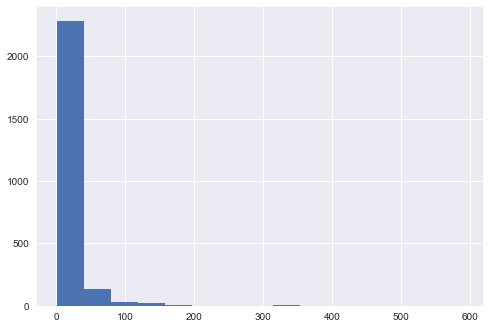

In [17]:
def days_between(df:pd.DataFrame) -> pd.Series:
    
    '''
    take the .diff() of the sorted list of all transaction dates for each household
    
    return the rounded mean: the average days_between_purchases
    
    '''
    
    days_between = dict()
    # loop through household_keys
    for key in df['household_key'].unique():

        # find the subset of transactions matching that household and  use .diff() to calculate the days between...
        # ...transactions; multiple transactions on the same day are ignored.
        a = pd.Series(df[df['household_key']==key]['DAY'].unique()).sort_values().diff()[1:]

        #calculate the mean difference between days of purchase
        days_between[key] = round(a.mean(), 2)


    ser = pd.Series(data=days_between.values(), index=days_between.keys())
#     ser.name = 'days_between_purchases'
    ser = pd.DataFrame(ser).reset_index()
    ser.columns=['household_key', 'days_between_purchases']
    return ser # included in the huge function below

days_between(merged)['days_between_purchases'].hist(bins=15);

## Massive Function to create hh_agg

In [18]:
def load_hh_agg(df) -> pd.DataFrame:
    '''accept the transactions (merged) table and return relevant house-level aggregations
    RESULTING COLUMNS:
        total_spend
        total_loyalty
        total_coupon
        total_quantity
        num_baskets
        unique_products
        first_purchase
        last_purchase
        avg_basket_spend
        avg_item_cost
        
        days_between_purchases (log-transformed)
        
        R
        F
        M
        RFM
        
    
    '''
    # - make hh agg
    # - add days between
    # - add section sales
    # - add RFM
    
    def make_hh_agg(df) -> pd.DataFrame:
        # group transactions by household key and aggregate:
        hh_agg = merged.groupby('household_key').agg(

        # total spend 
            total_spend=pd.NamedAgg(column="SALES_VALUE", aggfunc="sum"),
        # the total loyalty discount  
            total_loyalty=pd.NamedAgg(column="RETAIL_DISC", aggfunc="sum"), 
        # the total coupon match discount  
            total_coupon=pd.NamedAgg(column="COUPON_MATCH_DISC", aggfunc="sum"),
        # total quantity of items purchased   
            total_quantity=pd.NamedAgg(column='QUANTITY', aggfunc="sum"),

        # the number of baskets  
            num_baskets=pd.NamedAgg(column='BASKET_ID', aggfunc='nunique'),
        # number of unique of items purchased   
            unique_products=pd.NamedAgg(column='PRODUCT_ID', aggfunc='nunique'),

        # first day of purchase
            first_purchase=pd.NamedAgg(column='DAY', aggfunc='min'),
        # last day of purchase
            last_purchase=pd.NamedAgg(column='DAY', aggfunc='max'), 
                                                                    )

        ### Deriving Avg. Basket Spend and Avg. Item Cost --

        # average basket spend
        hh_agg['avg_basket_spend'] = hh_agg['total_spend']/hh_agg['num_baskets']

        # average item cost (total spend/quantity)
        hh_agg['avg_item_cost'] = hh_agg['total_spend']/hh_agg['total_quantity']

        return hh_agg.reset_index()
    
    
    def days_between(df):
        '''take the .diff() of the sorted list of transaction dates for each household;
        round the mean of that and return a Series of all households in df
        '''
        days_between = dict()
        # loop through household_keys
        for key in df['household_key'].unique():

            # find the subset of transactions matching that household and  use .diff() to calculate the days between...
            # ...transactions; multiple transactions on the same day are ignored.
            a = pd.Series(df[df['household_key']==key]['DAY'].unique()).sort_values().diff()[1:]

            #calculate the mean difference between days of purchase
            days_between[key] = round(a.mean(), 2)


        ser = pd.Series(data=days_between.values(), index=days_between.keys())
    #     ser.name = 'days_between_purchases'
        ser = pd.DataFrame(ser).reset_index()
        ser.columns=['household_key', 'days_between_purchases']
        return ser # included in the huge function below
    
    
    def get_section_sales(df) -> pd.DataFrame():
    
        idx = df.index
        # get dummies for each transaction row
        section_dummies = pd.get_dummies(df['Section Labels'])

        # multiply each row by it's SALES VALUE
        section_sales = section_dummies.apply(lambda x: x * df['SALES_VALUE'])
    #     print(all(section_sales.index == idx))
        # add and group by household key, sum all rows from the dummy columns
        section_sales = section_sales.join(df[['household_key']]).groupby('household_key').agg(sum)
        return section_sales.reset_index()
    
    
    def add_RFM(hh_agg, output_type='int'):
        ''' using pd.qcut to create equal-sized bins for R/F/M/RFM Score - Ranked 1-5 stars

        '''
        # save hh_agg household_key index
        index = hh_agg['household_key']

        labels = [5,4,3,2,1] 

        ### Recency
        r = np.array(hh_agg['last_purchase']) # based on last day of purchase; the higher the better
        r = pd.qcut(r, 5, labels=labels)
        r = pd.Series(r).astype(output_type)
        r.name = 'R'

        ### Frequency
        f = np.array(hh_agg['days_between_purchases']) # based on days between purchases; the lower the better
        f = pd.qcut(f, 5, labels=[1,2,3,4,5])
        f = pd.Series(f).astype(output_type)
        f.name = 'F'

        ### Monetary
        m = np.array(hh_agg['total_spend']) # based on total spend; could be avg. basket spend or item spend?
        m = pd.qcut(m, 5, labels=labels)
        m = pd.Series(m).astype(output_type)
        m.name = 'M'

        output = pd.concat([r,f,m], axis=1)
        ### Sum to get final score
        output['RFM'] = output[['R', 'F', 'M']].astype(output_type).sum(axis=1)
        output.index = index

        return output.reset_index()
    
    
    hh_agg = make_hh_agg(df).merge(get_section_sales(df)).merge(days_between(df))

    hh_agg.merge(add_RFM(hh_agg))
    
    return hh_agg

hh_agg = load_hh_agg(merged)  
# hh_agg.to_csv('data/outputs/hh_agg.csv')
hh_agg.head()

,household_key,total_spend,total_loyalty,total_coupon,total_quantity,num_baskets,unique_products,first_purchase,last_purchase,avg_basket_spend,...,grain_goods,grocery,home_family,junk_food,kitchen,meat,misc,produce,seasonal,days_between_purchases
0,1,4120.07,-642.14,-25.65,1901,81,655,101,706,50.865062,...,668.41,230.24,537.29,764.02,1.59,379.04,303.82,477.82,0.00,8.29
1,2,1954.34,-333.50,0.00,833,45,545,103,668,43.429778,...,144.89,47.21,477.92,255.63,7.98,277.78,139.88,212.41,6.99,12.84
2,3,2633.20,-667.59,-19.80,1589,46,513,113,703,57.243478,...,272.97,136.42,161.92,508.39,0.00,814.45,198.42,261.44,1.99,13.41
3,4,1200.11,-115.65,0.00,382,30,164,104,627,40.003667,...,93.72,85.07,148.71,261.64,0.00,135.09,60.13,18.71,0.00,18.03
4,5,695.32,-94.48,0.00,224,36,182,111,703,19.314444,...,17.42,15.96,162.64,34.12,3.99,154.29,81.88,12.64,1.29,21.14


In [19]:
hh_agg.to_csv('data/outputs/hh_agg.csv')

### **`RFM Score`:**

RFM score is a measure of the value of a customer; the name is an acronym for *Recency, Frequency, Monetary* score. The idea is to rank each household, from 1-5 stars, based on the recency, frequency, and monetary value of their past purchase behaviour.

In [ ]:
def add_RFM(hh_agg, output_type='int'):
    ''' using pd.qcut to create equal-sized bins for R/F/M/RFM Score - Ranked 1-5 stars
    
    '''
    # save hh_agg household_key index
    index = hh_agg['household_key']
    
    labels = [5,4,3,2,1] 
    
    ### Recency
    r = np.array(hh_agg['last_purchase']) # based on last day of purchase; the higher the better
    r = pd.qcut(r, 5, labels=labels)
    r = pd.Series(r).astype(output_type)
    r.name = 'R'

    ### Frequency
    f = np.array(hh_agg['days_between_purchases']) # based on days between purchases; the lower the better
    f = pd.qcut(f, 5, labels=[1,2,3,4,5])
    f = pd.Series(f).astype(output_type)
    f.name = 'F'

    ### Monetary
    m = np.array(hh_agg['total_spend']) # based on total spend; could be avg. basket spend or item spend?
    m = pd.qcut(m, 5, labels=labels)
    m = pd.Series(m).astype(output_type)
    m.name = 'M'
    
    output = pd.concat([r,f,m], axis=1)
    ### Sum to get final score
    output['RFM'] = output[['R', 'F', 'M']].astype(output_type).sum(axis=1)
    output.index = index
    
    return output.reset_index()

add_RFM(hh_agg)


## `hh_weekly` -- adding definition to purchase behaviour

In [54]:
def load_hh_tensors(df, 
                    resample_rule='W', ## SHOULD STAY WEEKLY; DURATION CALCULATION DEPENDS ON IT
                    resample_tag='weekly_',
                    dt_col='datetime', 
                    id_col='household_key', 
                    return_sequence=False, # not currently implemented
                    aggros=None, 
                    colnames=None):
    ''' resample timeseries and create aggregate windows for each timeframe
        return:
            the mean values for each listed column, along that time-window axis
    '''
    if not aggros:
    # aggregate functions dictionary to be applied to `resample_rule` subsections, 
        aggros = {'SALES_VALUE':'sum',
        'RETAIL_DISC':'sum',
        'BASKET_ID': 'nunique',
        'QUANTITY':'sum',
        'PRODUCT_ID':'sum',
        'alcohol':'sum',
        'beverages':'sum',       
        'concessions':'sum',
        'dairy':'sum',
        'drug':'sum', 
        'garden':'sum',
        'grain_goods':'sum',
        'grocery':'sum',
        'home_family':'sum',
        'junk_food':'sum',
        'kitchen':'sum',
        'meat':'sum',
        'misc':'sum',
        'produce':'sum',
        'seasonal':'sum'}
        
    if not colnames:
        colnames = ['sum_sales', 'retail_disc', 'num_baskets', 'quantity',
               'unique_products', 'alcohol', 'beverages', 'concessions', 'dairy', 'drug',
               'garden', 'grain_goods', 'grocery', 'home_family', 'junk_food',
               'kitchen', 'meat', 'misc', 'produce', 'seasonal']
    
    # map for new column names
    col_map = dict(zip(aggros.keys(), colnames))

    # adding descriptive label 'weekly_' to colnames
    colnames = [f'{resample_tag}{x}' for x in colnames]
    
    ### call get_section_sales to populate -- 
    df=df.merge(get_section_sales(df).reset_index())
    output = dict()
    
    first_day = df['WEEK_NO'].min()
    last_day = df['WEEK_NO'].max()
    duration = last_day - first_day + 1
    
    ### create the series for a given household, resampled by rule
    def get_series(hh, return_sequence=return_sequence, df=df, id_col=id_col, dt_col=dt_col):
        series = df[df[id_col]==hh].resample(resample_rule, on=dt_col).agg(aggros)
        
        if return_sequence==False:
            return series
        else:
            return series

    for household in df[id_col][:5].unique():
        output[int(household)] = get_series(household) # take only the mean

            ### FINALIZING TABLE

    output = pd.DataFrame(output).T    
    output.reset_index(inplace=True)
    output.columns = ['household_key'] + colnames

#     output['weekly_retail_disc'] = output['weekly_retail_disc'] * -1 ## hardcoded exception; reversing negative value
    
    return output

In [55]:
hh_tensors = load_hh_tensors(merged,resample_rule='W', )
# hh_tensors.to_csv('data/outputs/weekly_hh.csv')

In [56]:
hh_tensors

,household_key,weekly_sum_sales,weekly_retail_disc,weekly_num_baskets,weekly_quantity,weekly_unique_products,weekly_alcohol,weekly_beverages,weekly_concessions,weekly_dairy,...,weekly_garden,weekly_grain_goods,weekly_grocery,weekly_home_family,weekly_junk_food,weekly_kitchen,weekly_meat,weekly_misc,weekly_produce,weekly_seasonal
0,2319,9.229886,-1.5825,0.579545,4.170455,9641330.5,58.203068,263.799545,154.7325,172.162841,...,0.0,191.563864,87.695341,412.144318,365.935227,0.0,523.589773,167.881705,259.926136,71.250341


#  **`Market Basket Analysis`:**

*INPUTS:*

- Clean transaction and demographic information

*OUTPUTS:*

- Recency, Frequency, Monetary Scores -- 5 being the highest possible
- RFM is the aggregate score, indicating a frequent customer. But we already knew that about our customers.

Next we need to create an aggregate table to begin forming a profile of each household. 

Below is listed a sequence of steps to do so;
- take the row-level sales; map to binarized (dummy) columns and return the sum of sales for each section label at the household level
- add the frequency measure; days between
- create an aggregate table for household purchases; number of baskets; etc.
- rank each household 1-5 stars, based on Recency, Frequency, Monetary participation;

# Campaign Dashboard

An attempt at corralling the information about marketing campaigns into something useful; 

- each campaign has an associated product list
    - 'Section Label Counts'; a breakdown of the campaign by number of products in each category. Investigative and biased; fewer products listed does not equate to a lesser impact on sales by section.

- find the sales of products which were listed in the campaign, over the duration of the data

- calculate the average sales before;during;after;overall

- plot

In [92]:
def load_campaign_summary():
    
    def campaign_products():
        campaign_desc = pd.read_csv('data/campaign_desc.csv')
        coupon = pd.read_csv('data/coupon.csv')

        #### CONTAINER
        results = dict()

        for camp_no in range(1,31):
            #### RUSSIAN DOLL
            results[camp_no] = dict()


            #### FIRST AND LAST DAY
            first, last = list(campaign_desc[campaign_desc['CAMPAIGN'] == camp_no][['START_DAY', 'END_DAY']].iloc[0, :].values)
            # boundary assertions for first, last
            if first < merged['DAY'].min():
                first = merged['DAY'].min()
            if last > 711: # campaign 24 has an erroneous LAST_DAY
                last = 711
            # store first/last
            results[camp_no]['First Day'] = first
            results[camp_no]['Last Day'] = last

            #### TOTAL DURATION
            results[camp_no]['Duration'] = (last - first) +1



            #### PRODUCT LISTS
            results[camp_no]['Listed Products'] = coupon_list = list(coupon[coupon['CAMPAIGN'] == camp_no]['PRODUCT_ID'])
            #### SECTION LABELS 
            results[camp_no]['Section Label Counts'] = {v:k for (k, v) in zip(merged[merged['PRODUCT_ID'].isin(coupon_list)]['Section Labels'].value_counts(), merged[merged['PRODUCT_ID'].isin(coupon_list)]['Section Labels'].value_counts().index)}

            # Overall
            results[camp_no]['Listed Products Total Sales'] = merged[merged['PRODUCT_ID'].isin(coupon_list)]['SALES_VALUE'].sum()
            # avg. sales before the campaign
            results[camp_no]['Listed Products Sales Before'] = merged[merged['PRODUCT_ID'].isin(coupon_list) & (merged['DAY'] < first)]['SALES_VALUE'].sum()

            # avg. daily sales of mergeds in the campaign 
            # During the campaign 
            results[camp_no]['Listed Products Sales During'] = merged[(merged['PRODUCT_ID'].isin(coupon_list)) & (merged['DAY'].isin(range(first, last + 1)))]['SALES_VALUE'].sum()

            results[camp_no]['Listed Products Sales After'] = merged[(merged['PRODUCT_ID'].isin(coupon_list)) & (merged['DAY'] > last)]['SALES_VALUE'].sum()


        return results

    def campaign_sales():
        df = pd.DataFrame()
        product_lists = dict()

        for camp_no in range(1, 31):
        #     camp_no = 1
            first, last = list(campaign_desc[campaign_desc['CAMPAIGN'] == camp_no][['START_DAY', 'END_DAY']].iloc[0, :].values)
            coupon_list = list(coupon[coupon['CAMPAIGN'] == camp_no]['PRODUCT_ID'])
            product_lists[camp_no] = coupon_list

            # Assertion for day limits
            if first < merged['DAY'].min():
                first = merged['DAY'].min()
            if last > 711: # campaign 24 has an erroneous LAST_DAY
                last = 711

            # avg. daily sales of products in the campaign, overall
            total = merged[merged['PRODUCT_ID'].isin(coupon_list)]['SALES_VALUE'].sum() / (712 - merged['DAY'].min())

            # avg. daily sales of products in the campaign, before the campaign
            before = merged[merged['PRODUCT_ID'].isin(coupon_list) & (merged['DAY'] < first)]['SALES_VALUE'].sum() / (first+1 - merged['DAY'].min())

            # avg. daily sales of products in the campaign , during the campaign
            during = merged[(merged['PRODUCT_ID'].isin(coupon_list)) & (merged['DAY'].isin(range(first, last + 1)))]['SALES_VALUE'].sum() / (last+1 - first)

            # avg daily sales of products in the campaign, after the campaign
            after = merged[(merged['PRODUCT_ID'].isin(coupon_list)) & (merged['DAY'] > last)]['SALES_VALUE'].sum() / (712-last)

            df = df.append(pd.Series([total, before, during, after, first, last]), ignore_index=True)

        # add index (campaign) and columns
        df.columns = ['avg. total', 'avg. before', 'avg. during', 'avg. after', 'first', 'last']
        df.index = (range(1,31))
        return df

    return pd.DataFrame(campaign_products()).T.join(campaign_sales())
    
    ## TODO: add totals?
    
campaign_summary = dict(load_campaign_summary().T)

## Plot campaign sales impact

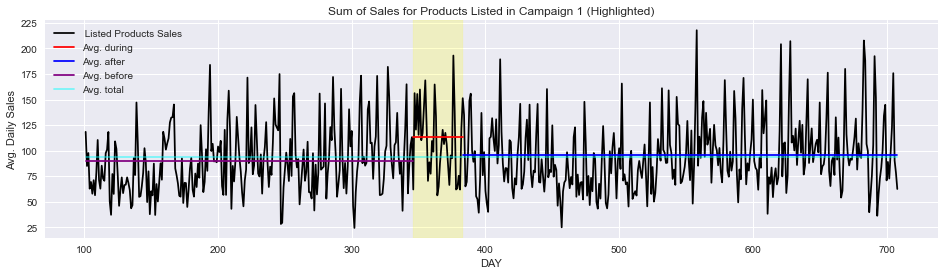

In [98]:
def plot_campaign_sales(campaign_summary, camp_no, merged):
    fig, ax = plt.subplots(figsize=(16,4))
    
    plt.title(f'Sum of Sales for Products Listed in Campaign {camp_no} (Highlighted)')
    plt.ylabel(f'Avg. Daily Sales')
    plt.xlabel('DAY')    
    
    first = campaign_summary[camp_no]['First Day']
    last = campaign_summary[camp_no]['Last Day']
    total_days = campaign_summary[camp_no]['Duration']
    product_list = campaign_summary[camp_no]['Listed Products']
    ### How Much Data
    trans_max = merged['DAY'].max()
    trans_min = merged['DAY'].min()

    merged[merged['PRODUCT_ID'].isin(product_list)].groupby('DAY')['SALES_VALUE'].sum().plot(color='black', label=' Listed Products Sales')
    plt.axvspan(first, last, alpha=0.2, color='yellow')

    val = campaign_summary[camp_no]['Listed Products Sales During'] / (last - first) + 1
    ax.plot((first, last), (val, val) , color='red', label='Avg. during')

    val = campaign_summary[camp_no]['Listed Products Sales After'] / (trans_max - last) + 1
    ax.plot((last, trans_max), (val, val) , color='blue', label='Avg. after')

    val = campaign_summary[camp_no]['Listed Products Sales Before'] / (first - trans_min) + 1 
    ax.plot((trans_min, first), (val, val) , color='purple', label='Avg. before')

    val = campaign_summary[camp_no]['Listed Products Total Sales'] / ((trans_max - trans_min) +1)
    ax.plot((trans_min, trans_max), (val, val) , color='cyan', label='Avg. total', alpha=0.5)
    plt.legend()
    plt.show()
    
plot_campaign_sales(campaign_summary, 1, merged)

In [101]:
campaign_summary[1]['Section Label Counts']

{'dairy': 13496, 'produce': 7565, 'beverages': 1567, 'meat': 1358, 'misc': 14}